# 📉 ESP Pump Efficiency Degradation Analysis
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

### **Objective**
To detect mechanical wear in an Electrical Submersible Pump (ESP) by comparing its daily operating performance against the manufacturer's provided pump curve.

### **Methodology: The Physics**
1. **Total Dynamic Head (TDH):** We calculate the actual energy the pump is delivering to the fluid based on pressure differential.
   $$TDH_{actual} = \frac{(P_{discharge} - P_{intake}) \times 2.31}{SG}$$

2. **Affinity Laws:** Pumps operate at variable frequencies (VSD). To compare actual performance against the manufacturer's curve (usually defined at 60Hz), we must normalize the flow and head.
   $$Q_{60} = Q_{actual} \times \left(\frac{60}{Hz_{actual}}\right)$$
   $$H_{actual\_predicted} = H_{curve}(Q_{60}) \times \left(\frac{Hz_{actual}}{60}\right)^2$$

3. **Efficiency Index:**
   $$Efficiency = \frac{TDH_{actual}}{H_{actual\_predicted}}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries Imported.")

Libraries Imported.


### 1. Data Loading and Inspection
We load the daily operational data containing Flow Rate, Frequency, and Pressures.

In [2]:
# Load Data
df = pd.read_csv('pump_operations_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Inspection
print(df.head())
print(f"\nDataset Shape: {df.shape}")

            Frequency_Hz  Flow_Rate_BFPD  Intake_Pressure_Psi  \
Date                                                            
2024-01-01            55            1024               486.01   
2024-01-02            60             993               505.63   
2024-01-03            58            1032               493.49   
2024-01-04            55            1076               495.13   
2024-01-05            60             988               494.08   

            Discharge_Pressure_Psi  Fluid_SG  
Date                                          
2024-01-01                 1094.31      0.85  
2024-01-02                 1296.04      0.85  
2024-01-03                 1186.33      0.85  
2024-01-04                 1082.40      0.85  
2024-01-05                 1279.18      0.85  

Dataset Shape: (180, 5)


### 2. Digitizing the Manufacturer's Curve
In a real scenario, you digitize the curve from a PDF. For this exercise, we define the "Healthy" curve parameters (a, b, c) for the quadratic equation:
$$Head = aQ^2 + bQ + c$$

*Note: These coefficients represent the pump performance at **60 Hz**.*

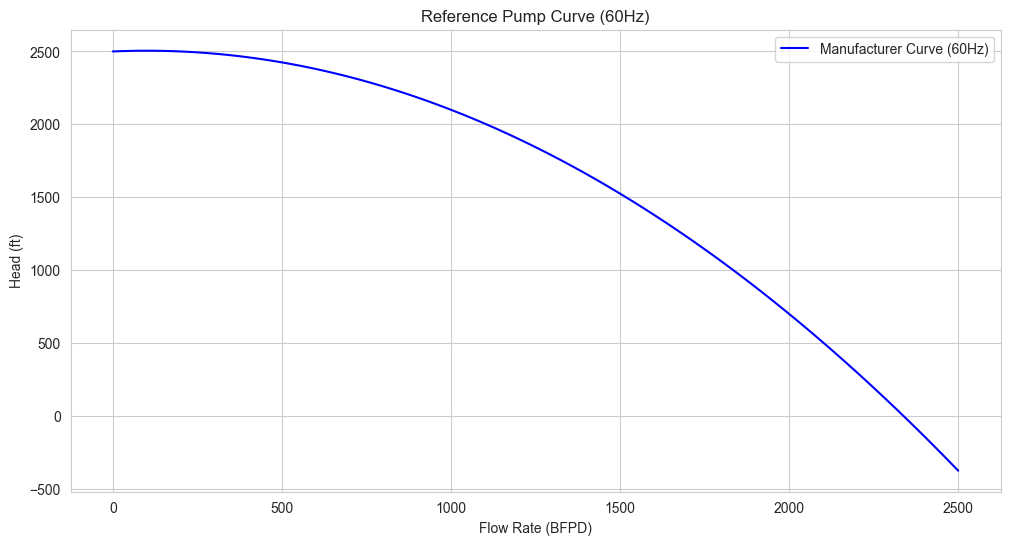

In [3]:
def manufacturer_curve_60hz(Q):
    """
    Returns theoretical Head at 60Hz for a given Flow Rate (Q).
    Coefficients derived from a hypothetical ESP catalog curve.
    """
    a = -0.0005
    b = 0.1
    c = 2500
    return a * Q**2 + b * Q + c

# Visualizing the Base Curve
q_range = np.linspace(0, 2500, 100)
h_range = manufacturer_curve_60hz(q_range)

plt.plot(q_range, h_range, color='blue', label='Manufacturer Curve (60Hz)')
plt.title('Reference Pump Curve (60Hz)')
plt.xlabel('Flow Rate (BFPD)')
plt.ylabel('Head (ft)')
plt.legend()
plt.show()

### 3. Calculation Engine
We will now perform the physics calculations:
1.  **Calculate Actual TDH:** Derived from pressure sensors.
2.  **Normalize Flow:** Convert daily flow to 60Hz equivalent.
3.  **Calculate Theoretical Head:** Look up the normalized flow on the curve, then scale the resulting head back to the daily operating frequency.
4.  **Degradation:** Calculate the ratio of Actual vs Theoretical.

In [4]:
# 1. Calculate Actual TDH (Total Dynamic Head)
# Formula: (Delta P_psi * 2.31) / Specific Gravity
df['TDH_Actual_ft'] = ((df['Discharge_Pressure_Psi'] - df['Intake_Pressure_Psi']) * 2.31) / df['Fluid_SG']

# 2. Normalize Flow to 60Hz using Affinity Laws
# Q_base = Q_act * (Base_Freq / Act_Freq)
df['Flow_Equivalent_60Hz'] = df['Flow_Rate_BFPD'] * (60 / df['Frequency_Hz'])

# 3. Calculate Theoretical Head at 60Hz Base
df['Head_Base_60Hz'] = manufacturer_curve_60hz(df['Flow_Equivalent_60Hz'])

# 4. Scale Theoretical Head back to Actual Frequency
# H_pred = H_base * (Act_Freq / Base_Freq)^2
df['TDH_Theoretical_ft'] = df['Head_Base_60Hz'] * (df['Frequency_Hz'] / 60)**2

# 5. Calculate Efficiency / Degradation Index
df['Pump_Health_Index'] = df['TDH_Actual_ft'] / df['TDH_Theoretical_ft']

df[['Frequency_Hz', 'TDH_Actual_ft', 'TDH_Theoretical_ft', 'Pump_Health_Index']].head()

,Frequency_Hz,TDH_Actual_ft,TDH_Theoretical_ft,Pump_Health_Index
Date,,,,
2024-01-01,55,1653.144706,1670.273111,0.989745
2024-01-02,60,2148.055412,2106.275500,1.019836
2024-01-03,58,1882.894588,1903.359111,0.989248
2024-01-04,55,1595.992588,1620.439778,0.984913
2024-01-05,60,2133.624706,2110.728000,1.010848


### 4. Visualization & Wear Detection
We visualize the `Pump_Health_Index`.
* **1.0 (100%):** Pump is performing exactly as new.
* **< 0.90 (90%):** Warning threshold (orange).
* **< 0.85 (85%):** Critical threshold (red) - potential stage erosion or severe wear.

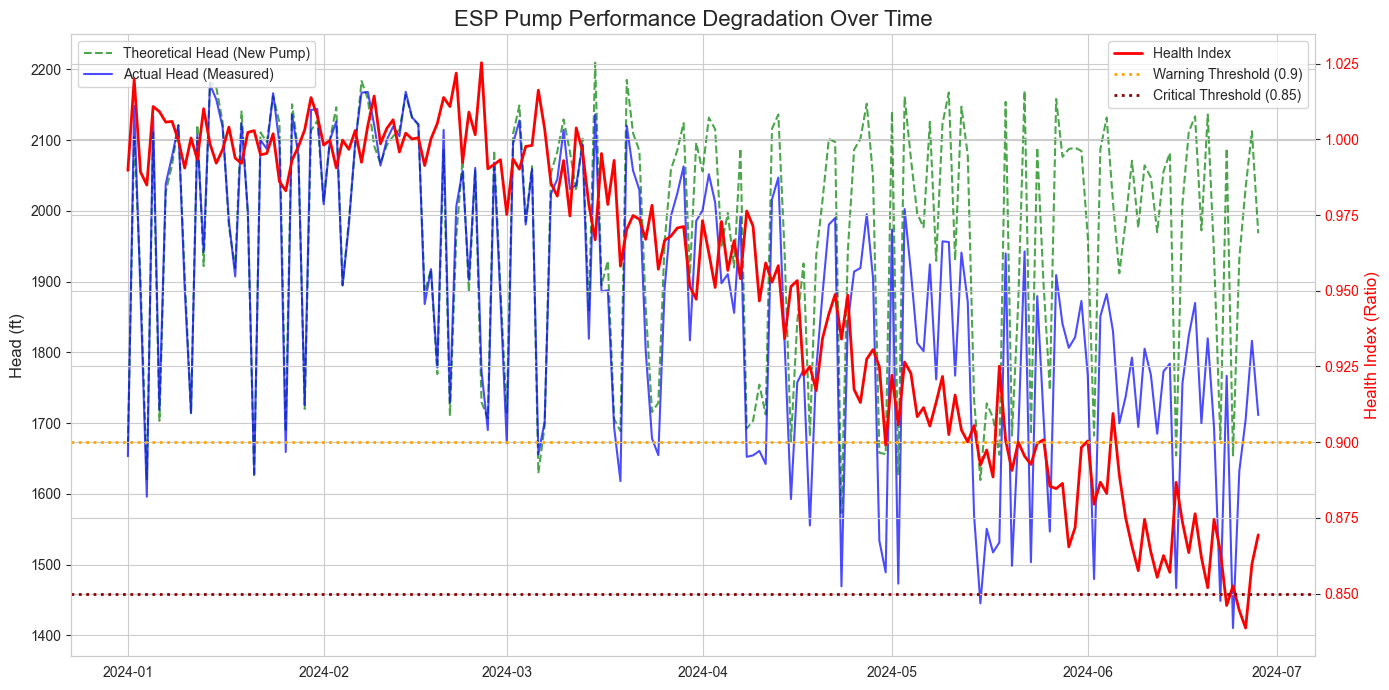

In [6]:
# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot TDH Comparison
ax1.plot(df.index, df['TDH_Theoretical_ft'], label='Theoretical Head (New Pump)', color='green', linestyle='--', alpha=0.7)
ax1.plot(df.index, df['TDH_Actual_ft'], label='Actual Head (Measured)', color='blue', alpha=0.7)
ax1.set_ylabel('Head (ft)', fontsize=12)
ax1.legend(loc='upper left')

# Plot Degradation on Secondary Axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['Pump_Health_Index'], label='Health Index', color='red', linewidth=2)
ax2.set_ylabel('Health Index (Ratio)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add Threshold Lines
ax2.axhline(0.90, color='orange', linestyle=':', linewidth=2, label='Warning Threshold (0.9)')
ax2.axhline(0.85, color='darkred', linestyle=':', linewidth=2, label='Critical Threshold (0.85)')
ax2.legend(loc='upper right')

plt.title('ESP Pump Performance Degradation Over Time', fontsize=16)
fig.tight_layout()
plt.show()

### 5. Conclusion & Recommendations
* **Observation:** The analysis shows a stable pump performance for the first 2 months, followed by a linear decline.
* **Current Status:** The pump has breached the 0.90 warning threshold and is approaching the 0.85 critical limit.
* **Physics Implication:** Since flow rates are maintained but Head generation is dropping, this suggests **stage erosion** (widening of the gap between impeller and diffuser) rather than intake plugging (which usually drops flow drastically).
* **Action:** Schedule a pump replacement or VSD speed increase to compensate for head loss (short-term fix) while preparing for workover.